In [3]:
import numpy as np
from matplotlib import pyplot as plt
from pyrap.measures import measures
from pyrap.quanta import quantity
%matplotlib inline

In [4]:
vla_d = np.asarray([[-1.60171e+06, -5.04201e+06, 3.5546e+06],
         [-1.60115e+06, -5.042e+06, 3.55486e+06],
         [-1.60072e+06, -5.04227e+06, 3.55467e+06],
         [-1.60119e+06, -5.042e+06, 3.55484e+06],
         [-1.60161e+06, -5.042e+06, 3.55465e+06],
         [-1.60116e+06, -5.04183e+06, 3.5551e+06],
         [-1.60101e+06, -5.04209e+06, 3.5548e+06],
         [-1.60119e+06, -5.04198e+06, 3.55488e+06],
         [-1.60095e+06, -5.04213e+06, 3.55477e+06],
         [-1.60118e+06, -5.04193e+06, 3.55495e+06],
         [-1.60107e+06, -5.04205e+06, 3.55482e+06],
         [-1.6008e+06, -5.04222e+06, 3.55471e+06],
         [-1.60116e+06, -5.04178e+06, 3.55516e+06],
         [-1.60145e+06, -5.04199e+06, 3.55474e+06],
         [-1.60123e+06, -5.04198e+06, 3.55486e+06],
         [-1.60153e+06, -5.042e+06, 3.5547e+06],
         [-1.60114e+06, -5.04168e+06, 3.55532e+06],
         [-1.60132e+06, -5.04199e+06, 3.55481e+06],
         [-1.60117e+06, -5.04187e+06, 3.55504e+06],
         [-1.60119e+06, -5.04202e+06, 3.55481e+06],
         [-1.60117e+06, -5.0419e+06, 3.55499e+06],
         [-1.60088e+06, -5.04217e+06, 3.55474e+06],
         [-1.60138e+06, -5.04199e+06, 3.55478e+06],
         [-1.60118e+06, -5.04195e+06, 3.55492e+06],
         [-1.60127e+06, -5.04198e+06, 3.55483e+06],
         [-1.60111e+06, -5.04202e+06, 3.55484e+06],
         [-1.60115e+06, -5.04173e+06, 3.55524e+06]])

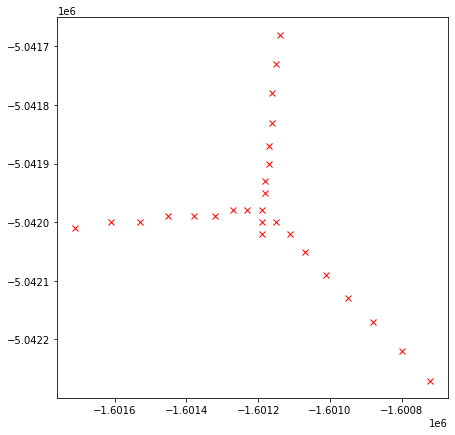

In [5]:
plt.figure(figsize=(7, 7))
plt.plot(vla_d[:, 0], vla_d[:, 1], "xr")
plt.show()

In [6]:
def antenna_indicies(na, auto_correlations=True):
    """ Compute base antenna pairs from baseline index """
    k = 0 if auto_correlations == True else 1
    ant1, ant2 = np.triu_indices(na, k)
    return np.stack([ant1, ant2], axis=1)

def _synthesize_uvw(station_ECEF, time, a1, a2, phase_ref):
    """
    Synthesizes new UVW coordinates based on time according to NRAO CASA convention (same as in fixvis)
    User should check these UVW coordinates carefully - if time centroid was used to compute
    original uvw coordinates the centroids of these new coordinates may be wrong, depending on whether
    data timesteps were heavily flagged.

    station_ECEF: ITRF station coordinates read from MS::ANTENNA
    time: time column, preferably time centroid (padded to nrow = unique time * unique bl)
    a1: ANTENNA_1 index (padded to nrow = unique time * unique bl)
    a2: ANTENNA_2 index (padded to nrow = unique time * unique bl)
    phase_ref: phase reference centre in radians
    """
    assert time.size == a1.size
    assert a1.size == a2.size

    dm = measures()
    epoch = dm.epoch("UT1", quantity(time[0], "s"))
    refdir = dm.direction("j2000", quantity(phase_ref[0], "rad"), quantity(phase_ref[1], "rad")) 
    obs = dm.position("ITRF", quantity(station_ECEF[0, 0], "m"), quantity(station_ECEF[0, 1], "m"), quantity(station_ECEF[0, 2], "m"))

    #setup local horizon coordinate frame with antenna 0 as reference position
    dm.do_frame(obs)
    dm.do_frame(refdir)
    dm.do_frame(epoch)

    ants = np.concatenate((a1, a2))
    unique_ants = np.unique(ants)
    unique_time = np.unique(time)
    na = unique_ants.size
    nbl = na * (na - 1) // 2 + na
    ntime = unique_time.size
    assert time.size == nbl * ntime, "Input arrays must be padded to include autocorrelations, all baselines and all time"
    antindices = antenna_indicies(na, auto_correlations=True)
    new_uvw = np.zeros((ntime*nbl, 3))
    lmat = np.triu((np.cumsum(np.arange(na)[None, :] >=
                              np.arange(na)[:, None]) - 1).reshape([na, na]))
    for ti, t in enumerate(unique_time):
        epoch = dm.epoch("UT1", quantity(t, "s"))
        dm.do_frame(epoch)

        station_uv = np.zeros_like(station_ECEF)
        for iapos, apos in enumerate(station_ECEF):
            station_uv[iapos] = dm.to_uvw(dm.baseline("ITRF", quantity([apos[0], station_ECEF[0, 0]], "m"),
                                                               quantity([apos[1], station_ECEF[0, 1]], "m"),
                                                               quantity([apos[2], station_ECEF[0, 2]], "m")))["xyz"].get_value()[0:3]
        for bl in range(nbl):
            blants = antindices[bl]
            bla1 = blants[0]
            bla2 = blants[1]
            new_uvw[ti*nbl + bl, :] = station_uv[bla1] - station_uv[bla2] # same as in CASA convention (Convention for UVW calculations in CASA, Rau 2013)

    return new_uvw

In [7]:
na = 27
nbl = na * (na - 1) // 2 + na
ntime = 1000
padded_a1 = np.empty((nbl), dtype=np.int32)
padded_a2 = np.empty((nbl), dtype=np.int32)
antindies = antenna_indicies(na)
for bl in range(nbl):
    blants = antindies[bl]
    padded_a1[bl] = blants[0]
    padded_a2[bl] = blants[1]
time = np.linspace(4789242432.0, 4789268088.5, ntime).repeat(nbl)
padded_a1 = np.tile(padded_a1, ntime)
padded_a2 = np.tile(padded_a2, ntime)
uvw = _synthesize_uvw(vla_d, time, padded_a1, padded_a2, np.deg2rad([60, 30]))

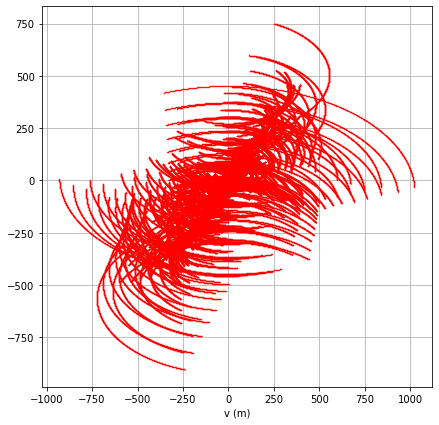

In [8]:
plt.figure(figsize=(7, 7))
plt.plot(uvw[:, 0], uvw[:, 1], ".r", markersize=0.5)
plt.grid(True)
plt.xlabel("u (m)")
plt.xlabel("v (m)")
plt.show()

In [9]:
def nngrid(uvw, w, oversample=1):
    max_uv = np.max(np.abs(uvw))
    NPIX = 2 * int(np.ceil(max_uv)) * oversample + ((2 * int(np.ceil(max_uv) * oversample) + 1) % 2)
    grid = np.zeros([NPIX, NPIX])
    for c, gw in zip(uvw, w):
        grid[int(np.round(c[0] + NPIX//2)), int(np.round(c[1] + NPIX//2))] += gw
    psf = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(grid))))
    return grid, psf / psf.max()

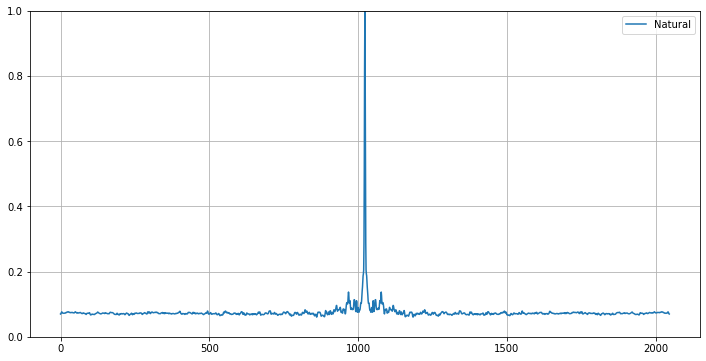

In [10]:
grid, psfnatural = nngrid(uvw, np.ones(uvw.shape[0]))
plt.figure(figsize=(12, 6))
plt.plot(psfnatural[psfnatural.shape[0]//2, 0:psfnatural.shape[0]], label="Natural")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

In [49]:
def taper(u, v, inner_cut, outer_cut, outer_taper_strength, inner_taper_strength, domain_restrict=1000.0): 
    uvdist = np.sqrt(u**2 + v**2)
    inner_cut = np.abs(inner_cut)
    outer_cut = np.abs(outer_cut)
    if inner_cut >= outer_cut:
        raise ValueError("Taper inner cut exceeds outer cut or outer cut left unset")
    outer_taper_strength = max(1.0e-6, 1 - np.cos(min(np.abs(outer_taper_strength), 1.0) * np.pi / 2))
    inner_taper_strength = max(1.0e-6, 1 - np.cos(min(np.abs(inner_taper_strength), 1.0) * np.pi / 2))
    def _sigmoid(x): 
        d = (1 + np.exp(-x))
        d[d == 0] = 1.0e-10
        return 1 / d
    
    y = (_sigmoid(-uvdist * outer_taper_strength + outer_cut * outer_taper_strength) +
         _sigmoid(+uvdist * inner_taper_strength - inner_cut * inner_taper_strength) +
         _sigmoid(+uvdist * outer_taper_strength + outer_cut * outer_taper_strength) + 
         _sigmoid(-uvdist * inner_taper_strength - inner_cut * inner_taper_strength)) - 2.0
    return y / np.max(y)

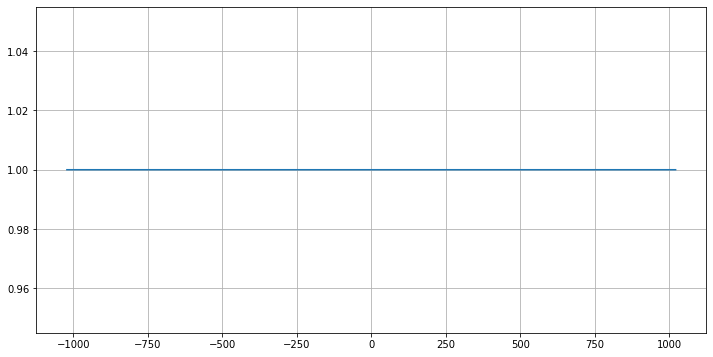

In [74]:
max_uv = np.max(np.abs(uvw))
u = np.linspace(-max_uv,max_uv, 6000)
v = np.zeros_like(u)
w = taper(u, v, 0, 1e6, 0.5, 0.5)

plt.figure(figsize=(12, 6))
plt.plot(u, w)
plt.grid(True)
plt.show()

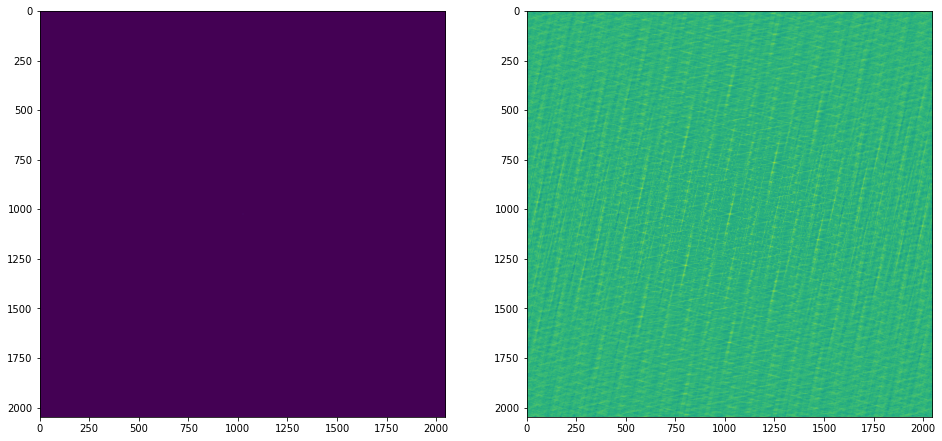

In [13]:
w = taper(u, v, 100, 500, 0.5, 0.25)
grid, psf = nngrid(uvw, w)
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(np.abs(grid))
plt.subplot(122)
plt.imshow(10*np.log10(np.abs(psf)))
plt.show()

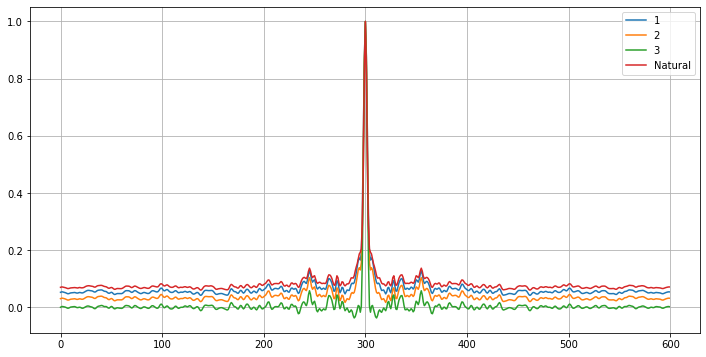

In [14]:
w = taper(uvw[:, 0], uvw[:, 1], 10, 500, 0.5, 0.25)
grid, psf1 = nngrid(uvw, w)
w = taper(uvw[:, 0], uvw[:, 1], 20, 500, 0.5, 0.25)
grid, psf2 = nngrid(uvw, w)
w = taper(uvw[:, 0], uvw[:, 1], 70, 500, 0.5, 0.25)
grid, psf3 = nngrid(uvw, w)
grid, psfnatural = nngrid(uvw, np.ones(uvw.shape[0]))
plt.figure(figsize=(12, 6))
plt.plot(psf1[psf.shape[0]//2, psf.shape[0]//2-300:psf.shape[0]//2+300], label="1")
plt.plot(psf2[psf.shape[0]//2, psf.shape[0]//2-300:psf.shape[0]//2+300], label="2")
plt.plot(psf3[psf.shape[0]//2, psf.shape[0]//2-300:psf.shape[0]//2+300], label="3")
plt.plot(psfnatural[psf.shape[0]//2, psf.shape[0]//2-300:psf.shape[0]//2+300], label="Natural")
plt.grid(True)
plt.legend()
plt.show()


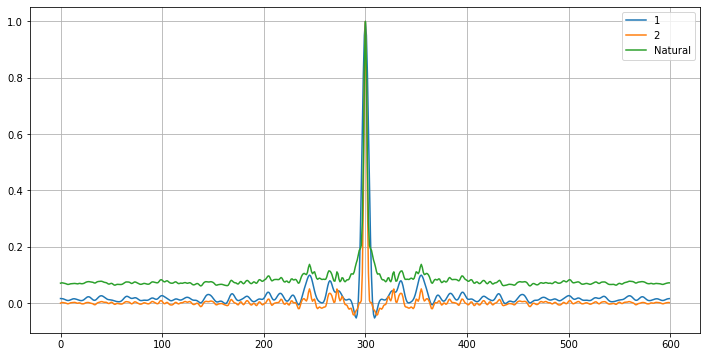

In [30]:
w = taper(uvw[:, 0], uvw[:, 1], 70, 200, 0.15, 0.2)
grid, psf1 = nngrid(uvw, w)
w = taper(uvw[:, 0], uvw[:, 1], 70, 1000, 0.5, 0.5)
grid, psf2 = nngrid(uvw, w)
grid, psfnatural = nngrid(uvw, np.ones(uvw.shape[0]))
plt.figure(figsize=(12, 6))
plt.plot(psf1[psf.shape[0]//2, psf.shape[0]//2-300:psf.shape[0]//2+300], label="1")
plt.plot(psf2[psf.shape[0]//2, psf.shape[0]//2-300:psf.shape[0]//2+300], label="2")
plt.plot(psfnatural[psf.shape[0]//2, psf.shape[0]//2-300:psf.shape[0]//2+300], label="Natural")
plt.grid(True)
plt.legend()
plt.show()